### Importo as bibliotecas necessárias

In [1]:
import numpy as np
import pandas as pd
import pandas_datareader as dt
import matplotlib.pyplot as plt

### Importo os dados dos setores

In [2]:
# Importo a plan com os dados do ibrx
ibrx_compo = pd.read_csv('IBrx Compo.csv', index_col=0)

# Transformo em uma lista
all_tickers = []
for column in range(0, len(ibrx_compo.columns)):
    for row in range(0, len(ibrx_compo.index)):
        if ibrx_compo.iloc[row, column] not in all_tickers and str(ibrx_compo.iloc[row, column]) != 'nan':
            all_tickers.append(ibrx_compo.iloc[row, column])

### Puxo os dados do yahoo

In [3]:
%%time
# Defino qual será a data de início dos dataframes de preços
start_date = '2010-01-01'

# Crio um dicionário que irá conter a série de preços de cada ação
prices_df = pd.DataFrame()

# Pego apenas a coluna Adjusted Close porque é o que me interessa
errors = []
for s in all_tickers:
    try:
        prices_df[s] = dt.DataReader(s, start=start_date, data_source='yahoo')['Adj Close']
    except:
        pass
        errors.append(s)      

Wall time: 3min 39s


In [4]:
# Pego os dados do ibovespa
ibov = dt.DataReader('^BVSP', start=start_date, data_source='yahoo')['Adj Close']    

### Tratando a base de dados

In [5]:
# Crio uma função que preenche dados vazios
def fill_values(df):
    for i in df.columns.values:
        init = df[i].first_valid_index()
        end = df[i].last_valid_index()
        df[i].loc[init:end]=df[i].loc[init:end].fillna(method='ffill')

In [6]:
# Preencho os valores descontinuos de precos
fill_values(prices_df)
prices_df.drop('TRPL4.SA', axis=1, inplace=True) #Estava com dados estranhos (saltos nos precos nao condizentes com a realidade)
prices_df['MGLU3.SA'] = prices_df['MGLU3.SA']+1 #Estava com precos negativos em 2014 (???)

### Metricas

In [7]:
# Calculo as medias moveis
MA15 = prices_df.rolling(15).mean()

# Calculo os desvios 
lower15 = MA15 - 2*prices_df.rolling(15).std()
upper15 = MA15 + 2*prices_df.rolling(15).std()

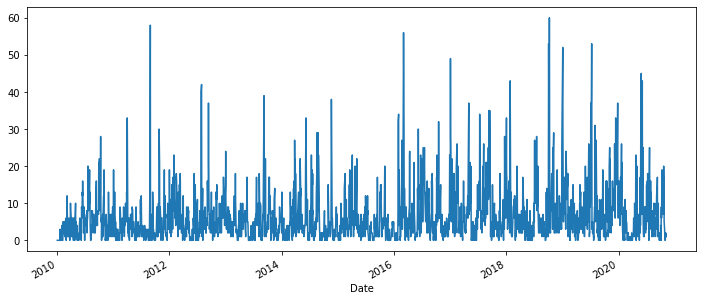

In [8]:
# Quando a oportunidade aparece
timing_buy = prices_df[prices_df<lower15]
timing_sell = prices_df[prices_df>upper15]

timing_sell.count(axis=1).plot(figsize=(12,5))

In [9]:
# Excluo os dias com mais de 10 acoes
new_timing = timing_buy[timing_buy.count(axis=1)<5]

timing_buy[:] = np.nan
timing_buy.loc[new_timing.index] = new_timing

# Sell
s_new_timing = timing_sell[timing_sell.count(axis=1)<5]

timing_sell[:] = np.nan
timing_sell.loc[s_new_timing.index] = s_new_timing

In [10]:
# Faco um dataframe que contem a data e as acoes que serao compradas
buys = {}
for date in timing_buy.index:
    buys.update({date:list(timing_buy.loc[date].dropna().index)})
    
buys_df = pd.DataFrame.from_dict(buys, orient='index')

# Faco um dataframe que contem a data e as acoes que serao vendidas
sells = {}
for date in timing_sell.index:
    sells.update({date:list(timing_sell.loc[date].dropna().index)})
    
sells_df = pd.DataFrame.from_dict(sells, orient='index')

In [11]:
# Faco o filtro do IBrX (se a acao nao estiver no indice no ano ela sera deletada da lista de compra)
for date in buys_df.index:
    buys = list(buys_df.loc[date].dropna())
    for b in range(0, len(buys)):
        if buys[b] not in list(ibrx_compo[str(date.year)]):
            buys_df.loc[date][b] = None
            
for date in sells_df.index:
    sells = list(sells_df.loc[date].dropna())
    for s in range(0, len(sells)):
        if sells[s] not in list(ibrx_compo[str(date.year)]):
            sells_df.loc[date][b] = None            

In [12]:
# Descubro quais acoes estao abaixo da media de 15 dias por mais de uma vez em 30 dias uteis 
roll_count = prices_df[prices_df<lower15].rolling(30).count()

s_roll_count = prices_df[prices_df<upper15].rolling(30).count()

### Retornos das estrategias

In [13]:
%%time
days = 1
b_returns = {}
for d in range(0,len(timing_buy.index)-days):
    #Buys
    # Seleciona as acoes com ordem de compra (d seria a data de compra e d+days a data da venda)
    df_tickers = prices_df.loc[timing_buy.index[d]:timing_buy.index[d+days],list(buys_df.loc[timing_buy.index[d]].dropna())].pct_change(days).tail(1)
    # Passa pelo filtro do rolling count
    list_count = roll_count.loc[timing_buy.index[d], list(df_tickers.columns)]
    df_tickers = df_tickers.drop(list(list_count[list_count>3].index), axis=1)
    
    # Retorno supondo equal weights
    b_date_return = df_tickers.mean(axis=1)
    #if str(b_date_return[0]) == 'nan':
    #   b_date_return = ibov[timing_buy.index].loc[timing_buy.index[d]:timing_buy.index[d+days]].pct_change().tail(1)
    
    b_returns.update({b_date_return.index[0]:b_date_return[0]})


Wall time: 9.29 s


In [25]:
%%time
s_returns = {}
for d in range(0,len(timing_sell.index)-days):
    #Sells
    # Seleciona as acoes com ordem de venda (d seria a data de venda e d+days a data da compra)
    df_tickers = prices_df.loc[timing_sell.index[d]:timing_sell.index[d+days],list(sells_df.loc[timing_sell.index[d]].dropna())].pct_change(days).tail(1)
    # Passa pelo filtro do rolling count
    list_count = roll_count.loc[timing_sell.index[d], list(df_tickers.columns)]
    df_tickers = df_tickers.drop(list(list_count[list_count>3].index), axis=1)
    
    s_date_return = (df_tickers.mean(axis=1))*-1
    
    s_returns.update({s_date_return.index[0]:s_date_return[0]})

Wall time: 9.45 s


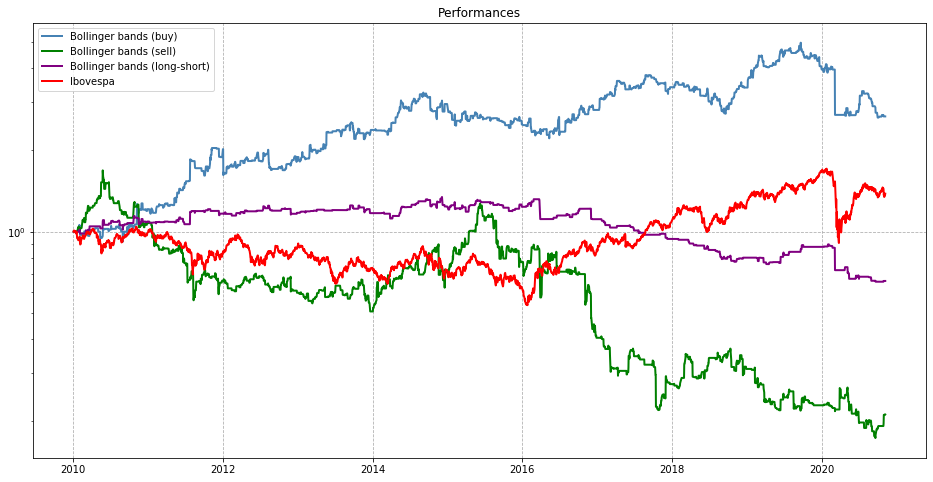

In [26]:
boll = (pd.Series(s_returns) + pd.Series(b_returns))/2

fig = plt.figure(figsize=(16,8))
ax = fig.add_subplot(1,1,1)

ax.plot(pd.Series(b_returns).fillna(0).add(1).cumprod(), c='steelblue', label='Bollinger bands (buy)', lw=2)
ax.plot(pd.Series(s_returns).fillna(0).add(1).cumprod(), c='green', label='Bollinger bands (sell)', lw=2)
ax.plot(boll.fillna(0).add(1).cumprod(), c='purple', label='Bollinger bands (long-short)', lw=2)
ax.plot((ibov/ibov.iloc[0]), c='red', label='Ibovespa', lw=2)
ax.legend(loc='best')
ax.set_yscale('log')
ax.set_title('Performances')
ax.grid(True, linestyle='--')
plt.show()

### Tabelas de retornos

In [16]:
b = pd.Series(b_returns).fillna(0).add(1).cumprod()
b_monthly_returns = b.groupby([b.index.year, b.index.month]).tail(1).pct_change()

table = pd.DataFrame(index=b_monthly_returns.groupby(b_monthly_returns.index.year).tail(1).index.year, columns=['01', '02', '03','04','05','06','07','08','09','10','11','12'])
for y in b_monthly_returns.groupby(b_monthly_returns.index.year).tail(1).index.year:
    for m in table.columns:
        if y == 2020 and m == '12':
            break
        table.loc[y][int(m)-1] = "{:.2%}".format(b_monthly_returns.loc[str(y)+'-'+m][0].round(4))


In [17]:
cumm = b.groupby(b.index.year).tail(1).pct_change()
cumm['2010-12-30'] = b.groupby(b.index.year).tail(1)[0]-1

In [18]:
table.columns = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
table['Acumulado'] = pd.Series(["{0:.2%}".format(val) for val in cumm], index = table.index)
table

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,Acumulado
2010,nan%,0.14%,1.20%,1.54%,-0.52%,-0.69%,2.60%,-4.17%,5.61%,0.63%,14.57%,-0.61%,20.97%
2011,-3.05%,6.80%,1.35%,-1.15%,10.20%,8.10%,23.04%,-6.86%,-2.96%,6.99%,14.34%,-7.48%,55.53%
2012,-8.54%,3.44%,2.40%,1.33%,-1.10%,-0.22%,5.62%,-11.54%,0.79%,-1.13%,5.07%,5.65%,0.13%
2013,0.22%,10.09%,-3.58%,0.90%,14.64%,1.13%,-4.17%,9.73%,-5.46%,-1.08%,-0.31%,3.16%,25.85%
2014,-0.45%,-0.04%,-0.36%,12.23%,8.79%,-2.81%,6.52%,7.56%,-2.37%,-10.81%,6.32%,-0.15%,24.61%
2015,-12.59%,-0.78%,1.40%,2.84%,-1.75%,-0.67%,0.17%,0.29%,-3.22%,-4.86%,8.00%,-4.69%,-15.97%
2016,1.82%,-6.88%,-2.83%,-0.66%,0.83%,0.54%,10.96%,1.78%,3.51%,2.47%,4.34%,-2.42%,13.16%
2017,9.88%,3.72%,7.30%,2.05%,-4.57%,2.13%,-0.88%,10.24%,-0.97%,-5.05%,-5.97%,3.24%,21.31%
2018,2.41%,-2.00%,-3.12%,2.92%,-7.03%,-4.82%,3.80%,-10.75%,1.17%,15.21%,5.68%,-1.34%,-0.30%
2019,15.36%,12.64%,-7.74%,0.21%,5.05%,4.27%,3.44%,-0.52%,0.09%,-5.74%,2.98%,-11.42%,16.54%


In [19]:
i = ibov.pct_change().add(1).cumprod()
i_monthly_returns = i.groupby([i.index.year, i.index.month]).tail(1).pct_change()

itable = pd.DataFrame(index=i_monthly_returns.groupby(i_monthly_returns.index.year).tail(1).index.year, columns=['01', '02', '03','04','05','06','07','08','09','10','11','12'])
for y in i_monthly_returns.groupby(i_monthly_returns.index.year).tail(1).index.year:
    for m in itable.columns:
        if y == 2020 and m == '12':
            break
        itable.loc[y][int(m)-1] = "{:.2%}".format(i_monthly_returns.loc[str(y)+'-'+m][0].round(4))

In [20]:
icumm = i.groupby(i.index.year).tail(1).pct_change()
icumm['2010-12-30'] = i.groupby(i.index.year).tail(1)[0]-1

In [21]:
itable.columns = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
itable['Acumulado'] = pd.Series(["{0:.2%}".format(val) for val in icumm], index = itable.index)
itable

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,Acumulado
Date,,,,,,,,,,,,,
2010,nan%,1.68%,5.82%,-4.04%,-6.64%,-3.35%,10.80%,-3.51%,6.58%,1.79%,-4.20%,2.36%,-1.06%
2011,-3.94%,1.21%,1.79%,-3.58%,-2.29%,-3.43%,-5.74%,-3.96%,-7.38%,11.49%,-2.51%,-0.21%,-18.11%
2012,11.13%,4.34%,-1.98%,-4.17%,-11.86%,-0.25%,3.20%,1.72%,3.71%,-3.56%,0.71%,6.05%,7.40%
2013,-1.95%,-3.91%,-1.87%,-0.78%,-4.30%,-11.31%,1.64%,3.68%,4.66%,3.66%,-3.27%,-1.86%,-15.50%
2014,-7.51%,-1.14%,7.05%,2.40%,-0.75%,3.76%,5.00%,9.78%,-11.70%,0.95%,0.06%,-8.52%,-2.91%
2015,-6.20%,9.97%,-0.84%,9.93%,-6.17%,0.61%,-4.17%,-8.33%,-3.36%,1.80%,-1.63%,-3.92%,-13.31%
2016,-6.79%,5.91%,16.97%,7.70%,-10.09%,6.30%,11.22%,1.03%,0.80%,11.24%,-4.65%,-2.71%,38.93%
2017,7.38%,3.08%,-2.52%,0.64%,-4.12%,0.30%,4.80%,7.46%,4.88%,0.02%,-3.15%,6.16%,26.86%
2018,11.14%,0.67%,-0.13%,0.88%,-10.87%,-5.20%,8.87%,-3.21%,3.47%,10.19%,2.38%,-1.81%,15.03%


## Estatisticas

In [22]:
corr = pd.Series(boll).fillna(0).corr(ibov.pct_change())
ibov_vol = (ibov.pct_change().dropna().std())*252**0.5
ibov_sharpe = (ibov.pct_change().dropna().mean())/(ibov.pct_change().dropna().std())*252**0.5
boll_vol_b = (pd.Series(b_returns).fillna(0).std())*252**0.5
boll_sharpe_b = (pd.Series(b_returns).fillna(0).mean())/(pd.Series(b_returns).fillna(0).std())*252**0.5
boll_vol_s = (pd.Series(s_returns).fillna(0).std())*252**0.5
boll_sharpe_s = (pd.Series(s_returns).fillna(0).mean())/(pd.Series(s_returns).fillna(0).std())*252**0.5
boll_vol_ls = (pd.Series(boll).fillna(0).std())*252**0.5
boll_sharpe_ls = (pd.Series(boll).fillna(0).mean())/(pd.Series(boll).fillna(0).std())*252**0.5

stats = pd.DataFrame(index=['Vol', 'Sharpe'], columns=['Ibov', 'B Bands (buy)', 'B Bands (sell)', 'B Bands (l-s)'])
stats['Ibov'] = [ibov_vol, ibov_sharpe]
stats['B Bands (buy)'] = [boll_vol_b,boll_sharpe_b]
stats['B Bands (sell)'] = [boll_vol_s,boll_sharpe_s]
stats['B Bands (l-s)'] = [boll_vol_ls,boll_sharpe_ls]
stats

,Ibov,B Bands (buy),B Bands (sell),B Bands (l-s)
Vol,0.253234,0.266807,0.370159,0.128084
Sharpe,0.247181,0.482805,-0.201053,-0.241426
